# XGBoost Regression

In [ ]:
from sklearn import datasets
import xgboost as xgb
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
data = datasets.fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
target = pd.DataFrame(data.target, columns=['MedHouseVal'])


# Splitting test and training set, from https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas
msk = np.random.rand(len(df)) <=0.8
X_train = df[msk]
y_train = target[msk]
X_test = df[~msk]
y_test = target[~msk]

# Number of iteractions
learning_rate = 0.1
# Terminal node
J = 6 
num_iteration = 800


Average Absolute Error:  0.2888738093575333


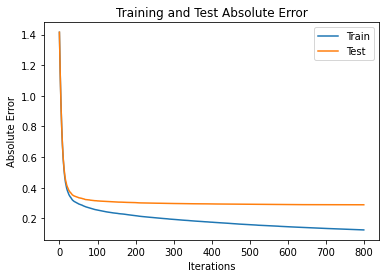

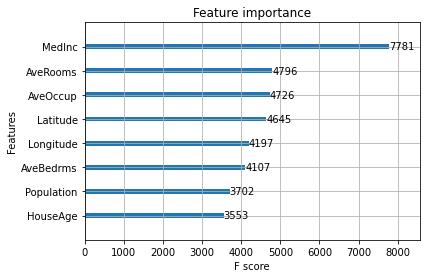

In [ ]:
from xgboost import XGBRegressor
def xgb_train(X_train, y_train, X_test, y_test):
  # dtrain = xgb.DMatrix(X_train, label = y_train)
  # dtest = xgb.DMatrix(X_test, label = y_test)
  xgb_reg = XGBRegressor(n_estimators = num_iteration, objective = 'reg:squarederror', max_depth=J, learning_rate=0.1)    
  # evallist = [(dtest, 'test'), (dtrain,'train')]
  evallist = [(X_train, y_train, 'train'),(X_test, y_test, 'test')]
  xgb_reg.fit(X_train, y_train, eval_metric = ['mae'], eval_set=evallist, verbose=0)
  y_pred = xgb_reg.predict(X_test)
  # print(y_test.to_numpy().tolist())
  # print()
  # print(y_pred)
  error = np.zeros((len(y_pred),1))
  for i in range(len(y_pred)):
      error[i] = abs(y_pred[i] - y_test.to_numpy()[i])
  aae = np.mean(error)
  print("Average Absolute Error: ", aae)

  
  AAEs = xgb_reg.evals_result()
  n = range(0, num_iteration)
  plt.plot(n, AAEs['validation_0']['mae'], label = 'Train')
  plt.plot(n, AAEs['validation_1']['mae'], label = 'Test')
  plt.legend()
  plt.title('Training and Test Absolute Error')
  plt.ylabel('Absolute Error')
  plt.xlabel('Iterations')
  plt.show()

  xgb.plot_importance(xgb_reg)
xgb_train(X_train, y_train, X_test, y_test)

# Chosen Dataset - Wine Quality

This dataset is obtained from https://archive.ics.uci.edu/ml/datasets/Wine+Quality


In [ ]:
'''
1 - fixed acidity
2 - volatile acidity
3 - citric acid
4 - residual sugar
5 - chlorides
6 - free sulfur dioxide
7 - total sulfur dioxide
8 - density
9 - pH
10 - sulphates
11 - alcohol
Output variable (based on sensory data):
12 - quality (score between 0 and 10)
'''
def load_dataset2():
  url = "https://raw.githubusercontent.com/1995hyz/Frequentist_ML/master/winequality-red.csv"
  df = pd.read_csv(url, sep = ";")
  return df

df = load_dataset2()
label = df['quality']
X = df.drop(labels=["quality"], axis = 1)

# Splitting test and train dataset
msk = np.random.rand(len(df)) <=0.8
X_train = X[msk]
y_train = label[msk]
X_test = X[~msk]
y_test = label[~msk]


In [ ]:
'''
      This section is designed to Tune the model in order to optimizae the performance
'''
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

def get_optimized(X_train, y_train, X_test, y_test):
  evallist = [(X_train, y_train),(X_test, y_test)]
  #initialization of number of iteractions, different learning rate, different depth of tree
  num = np.arange(300,1400,200)
  n_learning = np.arange(0.05, 0.5, 0.05)
  n_depth = np.arange(3,14,1)
  accuracy = np.zeros((len(num),len(n_learning),len(n_depth)))
  for x,i in enumerate(num):
    for y,j in enumerate(n_learning):
      for z,k in enumerate(n_depth):
        model = XGBClassifier(n_estimators=i, objective = 'reg:logistic', max_depth = k, learning_rate = j)
        model.fit(X_train, y_train, eval_metric="merror", eval_set = evallist, verbose=False)
        y_pred = model.predict(X_test)
        # Calculating accuracy score by using sklearn
        acc = accuracy_score(y_pred, y_test)
        accuracy[x][y][z] = acc
  index = np.unravel_index(np.argmax(accuracy, axis = None), accuracy.shape)
  best_numerator = num[index[0]]
  best_learning_rate = n_learning[index[1]]
  best_depth = n_depth[index[2]]
  print("best index, ", index)
  print("numerator: ", best_numerator)
  print("learning rate: ", best_learning_rate)
  print("depth: ", best_depth)
  return best_numerator, best_learning_rate, best_depth

num, learn_rate, depth = get_optimized(X_train, y_train, X_test, y_test)


best index,  (0, 2, 9)
numerator:  300
learning rate:  0.15000000000000002
depth:  12


In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import mean_absolute_error

num = 300
learn_rate = 0.15
depth = 12

def get_classification(num, learn_rate, depth, X_train, X_test, y_train, y_test):
  evallist = [(X_train, y_train),(X_test, y_test)]
  model = XGBClassifier(n_estimators=num, objective = 'reg:logistic', max_depth = depth, learning_rate = learn_rate)
  model.fit(X_train, y_train, eval_metric="merror", eval_set = evallist, verbose=False)
  y_pred = model.predict(X_test)
  # Calculating accuracy score by using sklearn
  accuracy = mean_absolute_error(y_pred, y_test)
  base = np.ones(y_pred.shape) * np.mean(y_train)
  b = base.reshape(len(y_test))
  baseline = mean_absolute_error(b, np.array(y_test))
  print("Accuracy of the baseline using Classifier: ", baseline)
  print("Accuracy of the model using Regressor: ", accuracy)

get_classification(num, learn_rate, depth, X_train, X_test, y_train, y_test)

Accuracy of the baseline:  0.6690355087518208
Accuracy of the model:  0.3424242424242424


In [ ]:
from sklearn.model_selection import GridSearchCV

parameter = {
    'n_esitmators': [300,350,400,500,700,800],
    'max_depth': [3,4,5,6,7,8,9,10],
    'learning_rate': [0.05, 0.1,0.15,0.2],
    'reg_alpha': [0.03],
    'reg_lambda': [0.05,0.1,0.8],
    'min_split_loss': [0.5,1]
}

model = xgb.XGBRegressor(objective= "reg:squarederror")
best = GridSearchCV(estimator=model, param_grid=parameter, n_jobs=5, cv=4, verbose=True)
best.fit(X_train, y_train)

print(best.best_params_)

Fitting 4 folds for each of 1152 candidates, totalling 4608 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  40 tasks      | elapsed:    5.7s
[Parallel(n_jobs=5)]: Done 190 tasks      | elapsed:   15.6s
[Parallel(n_jobs=5)]: Done 440 tasks      | elapsed:   38.1s
[Parallel(n_jobs=5)]: Done 790 tasks      | elapsed:  1.4min
[Parallel(n_jobs=5)]: Done 1240 tasks      | elapsed:  2.7min
[Parallel(n_jobs=5)]: Done 1790 tasks      | elapsed:  3.5min
[Parallel(n_jobs=5)]: Done 2440 tasks      | elapsed:  5.1min
[Parallel(n_jobs=5)]: Done 3190 tasks      | elapsed:  6.6min
[Parallel(n_jobs=5)]: Done 4040 tasks      | elapsed:  8.2min


{'learning_rate': 0.1, 'max_depth': 5, 'min_split_loss': 1, 'n_esitmators': 300, 'reg_alpha': 0.03, 'reg_lambda': 0.8}


[Parallel(n_jobs=5)]: Done 4608 out of 4608 | elapsed:  9.8min finished


Average Absolute Error:  0.3964131684465842


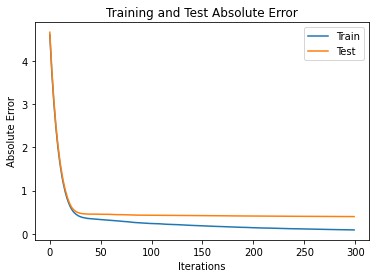

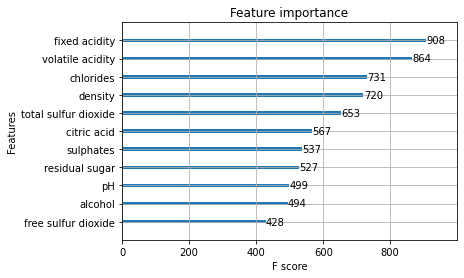

In [ ]:
# {'learning_rate': 0.1, 'max_depth': 5, 'min_split_loss': 1, 'n_esitmators': 300, 'reg_alpha': 0.03, 'reg_lambda': 0.8}
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
evallist = [(X_train, y_train),(X_test, y_test)]

model = xgb.XGBRegressor(n_estimators=300,objective='reg:squarederror',max_depth=5, learning_rate=0.1,reg_alpha=0.03,reg_lambda=0.8)
model.fit(X_train, y_train, eval_metric=['mae'], eval_set=evallist,verbose=0)
y_pred = model.predict(X_test)
accuracy = mean_absolute_error(y_pred, y_test)
base = np.ones(y_pred.shape) * np.mean(y_train)
b = base.reshape(len(y_test))
baseline = mean_absolute_error(b, np.array(y_test))
print("Accuracy of the baseline: ", baseline)
print("Accuracy of the model: ", accuracy)

AAEs = model.evals_result()
n = range(0, 300)
plt.plot(n, AAEs['validation_0']['mae'], label = 'Train')
plt.plot(n, AAEs['validation_1']['mae'], label = 'Test')
plt.legend()
plt.title('Training and Test Absolute Error')
plt.ylabel('Absolute Error')
plt.xlabel('Iterations')
plt.show()

xgb.plot_importance(model)


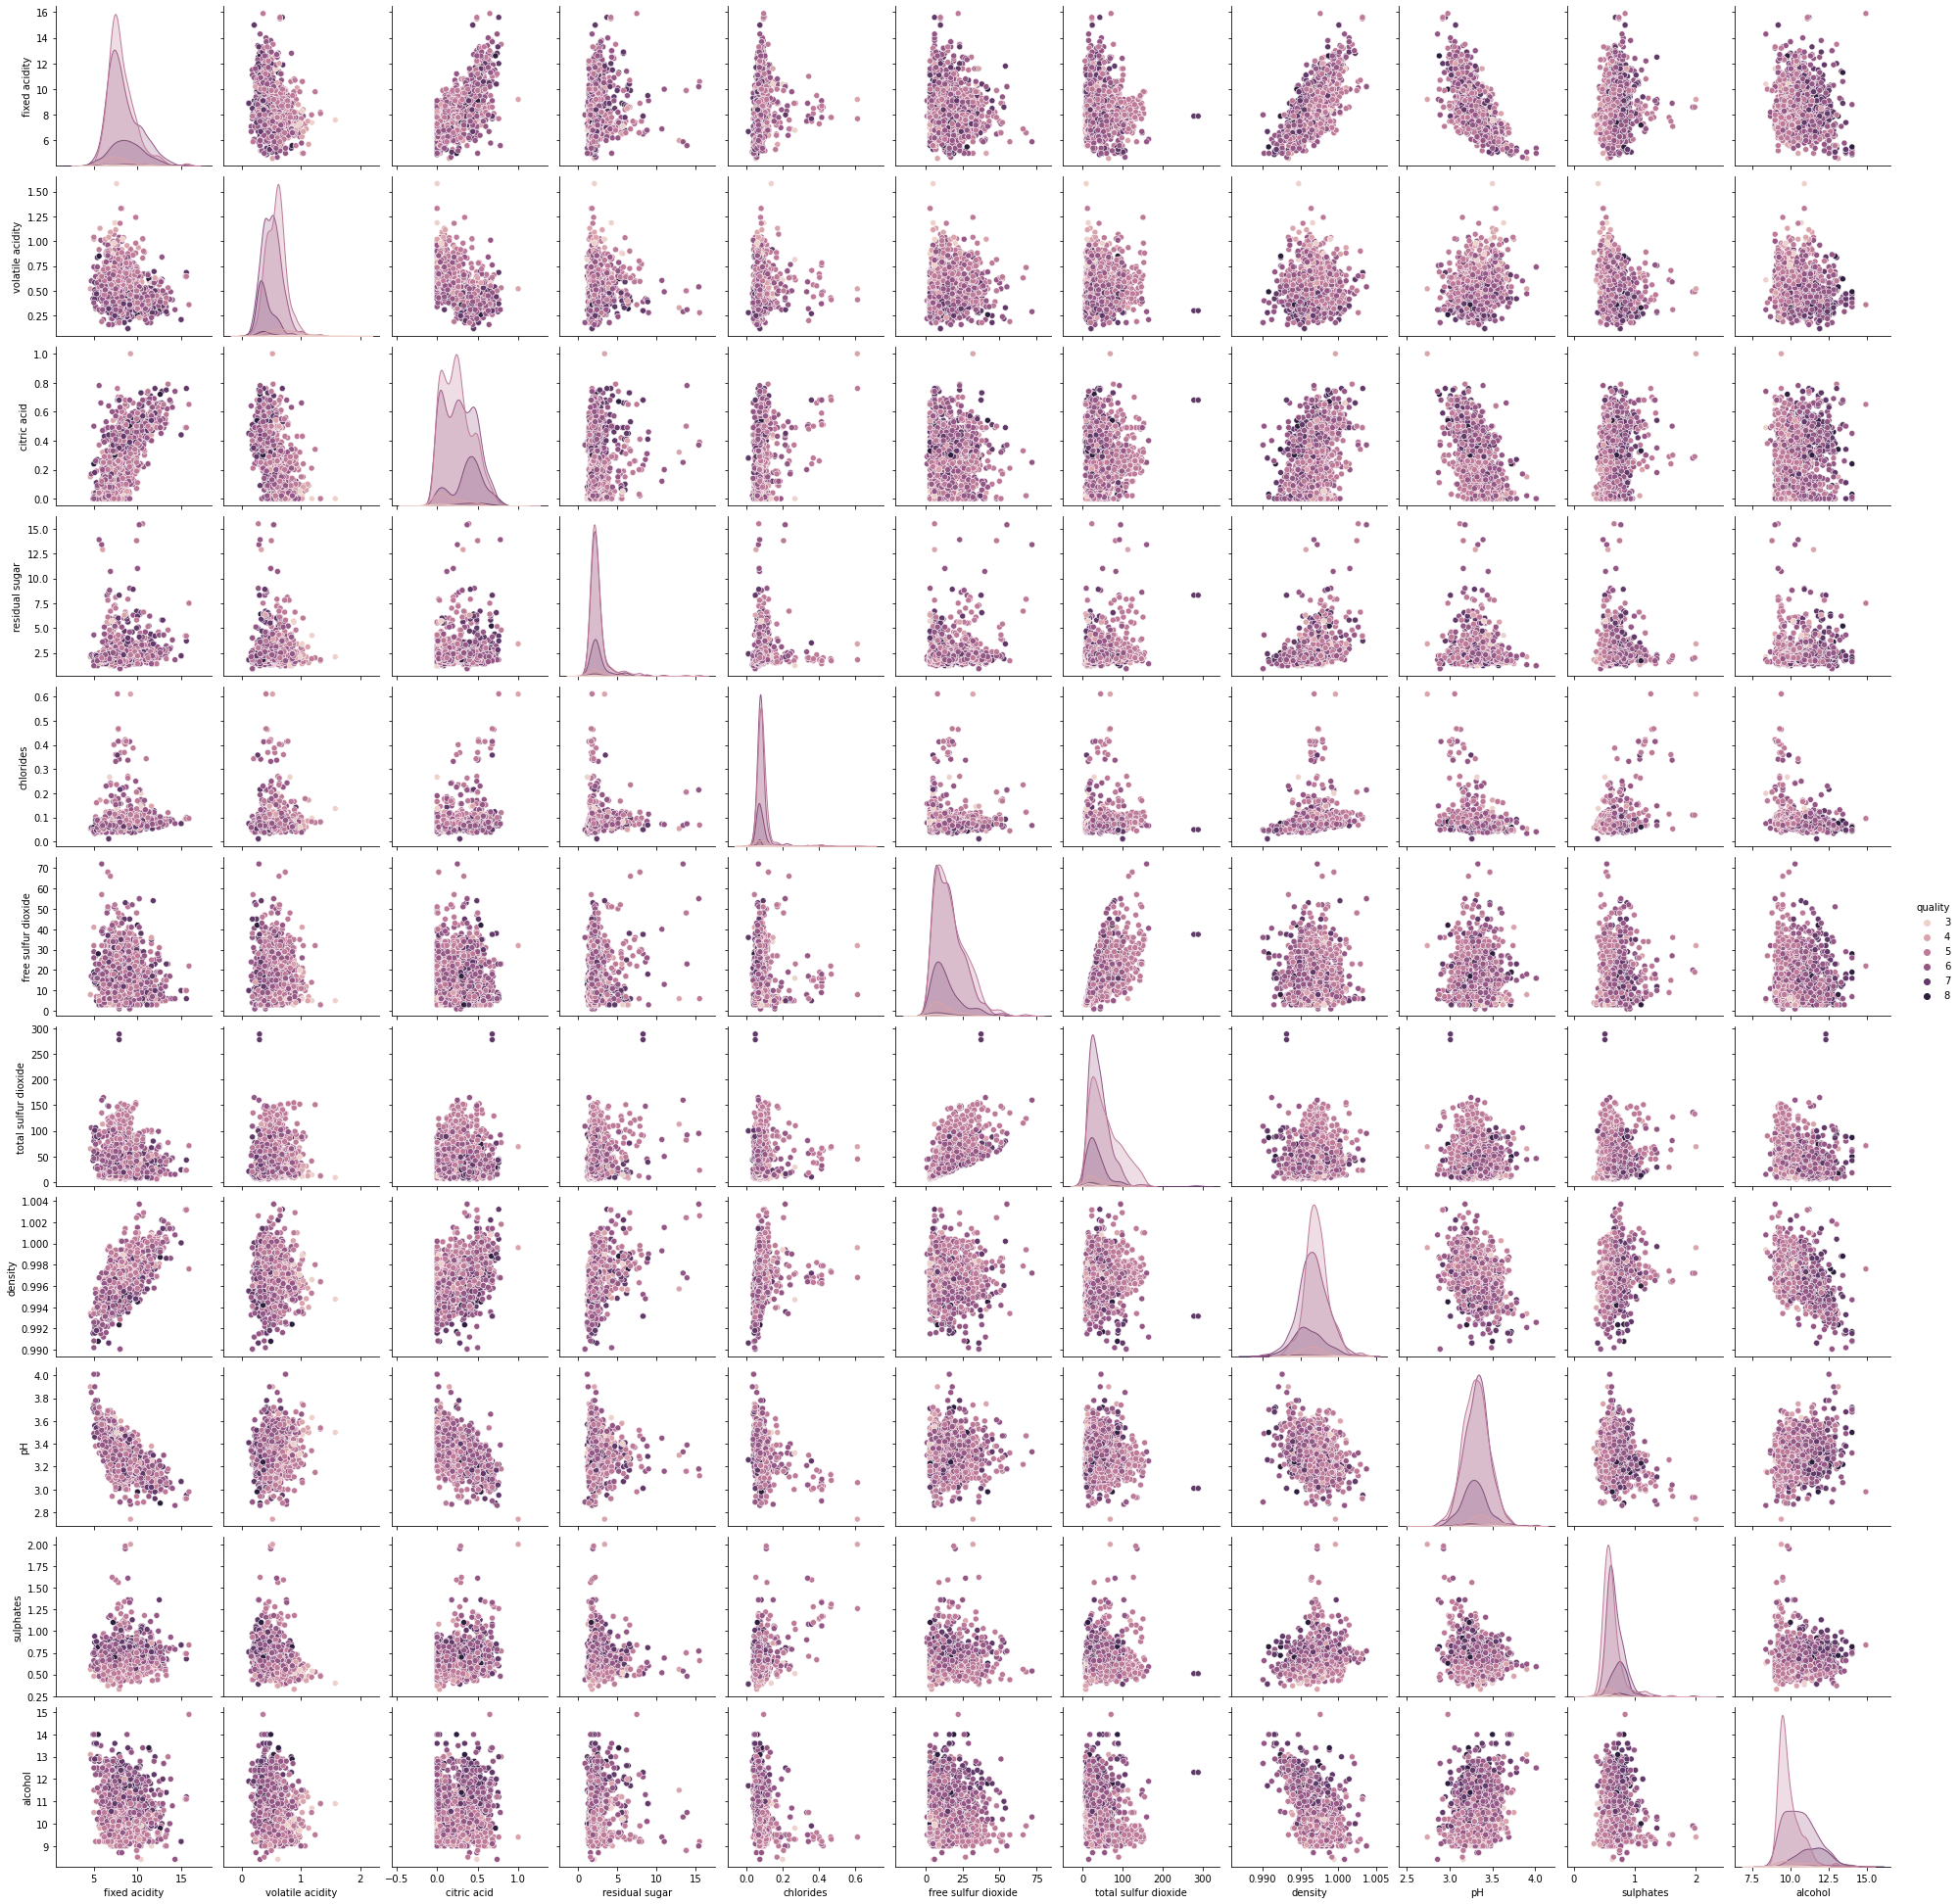

In [ ]:
import seaborn
seaborn.pairplot(df, hue = "quality")

For the dataset we chose, after trying to use Classifier and Regressor in Xgboost, shows a lower accuracy than the baseline accuracy.It is likely that the dataset is not suitable for using Boosting Tree as the model. The number of samples in this dataset is small also. From the seaborn plot above, we can see even though most of the qualities lie in between 5 to 8. The points are scattered in a way that for some of the features it is easy to differentiate each quality value, therefore the data's low-messiness could also contribute to the low accuracy of the model. As from the feature importance graph, the most important feature are fixed acidicity and volatile acidicity. Density and chlorides seem to also play important rules when making red wines.

# Stretch Goal1 - Implementing own tree


In [ ]:
import numpy as np
import pandas as pd
import random
from datetime import datetime

class Data(object):
    def __init__(self, data_frame):
        self.df = data_frame
        self.column_name = self.df.columns

    def get_data_train(self, target_label):
        length = int(0.8*len(self.df))
        data_training = self.df[:length].drop(labels=[target_label], axis=1)
        data_target = self.df[target_label][:length]
        data_training.insert(loc=data_training.shape[1], column=target_label, value=data_target)
        return np.array(data_training)

    def get_data_test(self, target_label):
        length_min = int(0.8 * len(self.df))
        length_max = int(0.9 * len(self.df))
        data_testing = self.df[length_min:length_max].drop(labels=[target_label], axis=1)
        data_target = self.df[target_label][length_min:length_max]
        data_testing.insert(loc=data_testing.shape[1], column=target_label, value=data_target)
        return np.array(data_testing)

    def get_data_validation(self, target_label):
        length_min = int(0.9 * len(self.df))
        data_validation = self.df[length_min:].drop(labels=[target_label], axis=1)
        data_target = self.df[target_label][length_min:]
        data_validation.insert(loc=data_validation.shape[1], column=target_label, value=data_target)
        return np.array(data_validation)

class Node:
    def __init__(self, predicted_class):
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None


class DecisionTreeClassifier:
    def __init__(self, data, max_depth, loss_func):
        self.max_depth = max_depth
        classes = set(data[:, -1])
        self.data = data
        self.tree = self.generate_tree(data, 0, classes, loss_func)

    @staticmethod
    def gini_index_formula(num_each_list, num_total):
        return 1.0 - sum((i / num_total) ** 2 for i in num_each_list)

    @staticmethod
    def misclassification_formula(num_each_list, num_total):
        return sum(1.0 - (i / num_total) for i in num_each_list)

    @staticmethod
    def cross_entropy_formula(num_each_list, num_total):
        return sum((i / num_total) * np.log10(i / num_total) for i in num_each_list)

    @staticmethod
    def mean_square_formula(label):
        label = np.array(label)
        mean = np.mean(label)
        return np.sum(np.square(label - mean)) / label.shape[0]

    def predict(self, feature, classes):
        result = []
        for row in feature:
            node = self.tree
            while node.left:
                if row[node.feature_index] < node.threshold:
                    node = node.left
                else:
                    node = node.right
            result.append(classes[node.predicted_class])
        return result

    def best_split(self, feature, label, classes, loss_func):
        best_index = None
        best_threshold = None
        num_classes = len(classes)
        num_total = len(label)
        # If all data has been used, return None
        if num_total <= 1:
            return best_index, best_threshold
        num_each_class = [np.sum(label == i) for i in classes]
        best_loss = 0
        if loss_func == "gini":
            best_loss = DecisionTreeClassifier.gini_index_formula(num_each_class, num_total)
        elif loss_func == "misclassification":
            best_loss = DecisionTreeClassifier.misclassification_formula(num_each_class, num_total)
        elif loss_func == "cross-entropy":
            best_loss = DecisionTreeClassifier.cross_entropy_formula(num_each_class, num_total)
        elif loss_func == "mean_square":
            best_loss = DecisionTreeClassifier.mean_square_formula(label)
        else:
            print("Invalid loss function.")
            exit(1)
        for index in range(feature.shape[1]):
          # Sort the data with label value to make the calculation of threshold easier. I got this idea from https://towardsdatascience.com/decision-tree-from-scratch-in-python-46e99dfea775
            thresholds, label_sorted = zip(*sorted(zip(feature[:, index], label)))
            num_left = [0] * num_classes
            num_right = num_each_class.copy()
            for i in range(1, num_total):
                c = label_sorted[i - 1]
                class_index = list(classes).index(c)
                # As we go through each entry in the dataset, keep moving entries from the right group to the left group
                num_left[class_index] += 1
                num_right[class_index] -= 1
                loss_left = 0
                loss_right = 0
                if loss_func == "gini":
                    loss_left = DecisionTreeClassifier.gini_index_formula(num_left, i)
                    loss_right = DecisionTreeClassifier.gini_index_formula(num_right, num_total-i)
                elif loss_func == "misclassification":
                    loss_left = DecisionTreeClassifier.misclassification_formula(num_left, i)
                    loss_right = DecisionTreeClassifier.misclassification_formula(num_right, num_total-i)
                elif loss_func == "cross-entropy":
                    loss_left = DecisionTreeClassifier.cross_entropy_formula(num_left, i)
                    loss_right = DecisionTreeClassifier.cross_entropy_formula(num_right, num_total-i)
                elif loss_func == "mean_square":
                    loss_left = DecisionTreeClassifier.mean_square_formula(label)
                    loss_right = DecisionTreeClassifier.mean_square_formula(label)
                else:
                    print("Invalid loss function.")
                    exit(1)
                loss_current = (i * loss_left + (num_total - i) * loss_right) / num_total
                if loss_current < best_loss:
                  # Update the best loss value is the current loss value is smaller.
                  # Update the threshold to be between the current label and the previous label
                    best_loss = loss_current
                    best_index = index
                    best_threshold = (thresholds[i] + thresholds[i - 1]) / 2
        return best_index, best_threshold

    def generate_tree(self, data, depth, classes, loss_func):
        if len(data) < 1:
            return Node(predicted_class=list(classes)[0])
        feature = data[:, 0:-1]
        label = data[:, -1]
        num_samples_per_class = [np.sum(label == i) for i in classes]
        predicted_class = np.argmax(num_samples_per_class)
        node = Node(predicted_class=predicted_class)
        if depth < self.max_depth:
            feature_index, threshold = self.best_split(feature, label, classes, loss_func)
            if feature_index is not None:
                # Split data based on the selected feature and threshold
                data_left = []
                data_right = []
                for row in data:
                    if row[feature_index] < threshold:
                        data_left.append(row)
                    else:
                        data_right.append(row)
                node.feature_index = feature_index
                node.threshold = threshold
                # Recursively generating tree
                node.left = self.generate_tree(np.array(data_left), depth + 1, classes, loss_func)
                node.right = self.generate_tree(np.array(data_right), depth + 1, classes, loss_func)
        return node

    def calculate_baseline(self):
        label = self.data[:, -1]
        classes = set(label)
        num_each_class = [np.sum(label == i) for i in classes]
        predicted_class = np.argmax(num_each_class)
        return num_each_class[int(predicted_class)] / len(label)


def accuracy_test(prediction, label):
    num_correct = 0
    for i in range(len(prediction)):
        if prediction[i] == label[i]:
            num_correct += 1
    return num_correct / len(prediction)


url = 'https://raw.githubusercontent.com/1995hyz/Frequentist_ML/master/winequality-red.csv'
df = pd.read_csv(url, sep=";")
random.seed(datetime.now())
df = df.sample(frac=1, random_state=random.randint(0, 200)).reset_index().drop(labels=["index"], axis=1)
data_processed = Data(df)
data_train = data_processed.get_data_train('quality')
data_validation = data_processed.get_data_validation('quality')
# Four different loss functions can be specified here: gini, misclassification, cross-entropy, mean_square
classifier = DecisionTreeClassifier(data_train, 4, "gini")
accuracy = accuracy_test(classifier.predict(data_validation[:, 0:-1], list(set(data_train[:, -1]))), data_validation[:, -1])
print("Accuracy: " + str(accuracy))
print("Baseline: " + str(classifier.calculate_baseline()))

Accuracy: 0.6
Baseline: 0.4214229867083659


# Stretch Goal 2 - Implementing Algorithm 10.3

Gradient Tree Boosting Algorithm on Californian Housing Dataset
Algorithm learned from here https://towardsdatascience.com/machine-learning-part-18-boosting-algorithms-gradient-boosting-in-python-ef5ae6965be4
 


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

data = datasets.fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
target = pd.DataFrame(data.target, columns=['MedHouseVal'])


# Splitting test and training set, from https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas
msk = np.random.rand(len(df)) <=0.8
X_train = df[msk]
y_train = target[msk]
X_test = df[~msk]
y_test = target[~msk]

tree_list = []

def model_gb(X_train, y_train, num, depth, learn):
  y_train_mean = y_train.mean()
  residual = y_train.copy() - y_train_mean.copy()
  for i in range(num):
    single_tree = DecisionTreeRegressor(criterion= "mae", max_depth=depth)
    single_tree.fit(X_train, residual.to_numpy())
    # Appened each tree to a list of trees
    tree_list.append(single_tree)
    #residual is equal to the sum of learning rate * the prediction of X_train
    predict = np.array(single_tree.predict(X_train)*learn).reshape(len(X_train),1)
    residual += predict
    return tree_list

def mae_prediction(X_test,y_test, tree_list, learning_rate):
  y_test_mean = y_test.mean()
  y_pred = y_test.mean().to_numpy() * np.ones((len(y_test),1))
  for i in range(len(tree_list)):
    y_pred += np.array(tree_list[i].predict(X_test) * learning_rate).reshape(len(X_test),1)  
  mae = mean_absolute_error(y_pred, y_test)
  return mae

num_estimator = 850
depth = 10
learn = 0.007

tree_model = model_gb(X_train, y_train, num_estimator, depth, learning_rate)

baseline = np.abs(y_test - y_test.mean()).mean().to_numpy()
print("Baseline Average Absolute Error: ", baseline)

gbr_accuracy = mae_prediction(X_test, y_test, tree_model, learn)
print("Gradient Boosting Tree Absolute Error: ", gbr_accuracy)

Baseline Average Absolute Error:  [0.90758111]
Gradient Boosting Tree Absolute Error:  0.9024381077120127
